In [52]:
from SimPEG import Mesh, Utils, Maps
import SimPEG.EM.Static.DC as DC
import SimPEG.EM.Static.Utils as DCUtils
import pylab as plt
from pylab import get_current_fig_manager
import time
import re
import scipy.interpolate as interpolation
from matplotlib import animation
from JSAnimation import HTMLWriter
from pymatsolver import PardisoSolver
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['dtype', 'f', 'plt', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [99]:
# Specify survey type
stype = 'pole-dipole'
dtype = 'appc'

# Survey parameters
a = 20 # Tx-Rx seperation
b = 10 # Dipole spacing
n = 1  # Number of Rx per Tx

# Model parameters (background, sphere1, sphere2)
sig = np.r_[1e-2,1e-1,1e-3]
eta = np.r_[0.,0.1, 0.1]

# Centroid of spheres
loc = np.c_[[-100.,0.,-100.],[100.,0.,-100.]]

# Radius of spheres
radi = np.r_[50.,50.]

# Forward solver
slvr = 'BiCGStab' #'LU'

# Preconditioner
pcdr = 'Jacobi'#

# Inversion parameter
pct = 0.01
flr = 5e-5
chifact = 100
ref_mod = 1e-2

# DOI threshold
cutoff = 0.8

# number of padding cells
padc = 0

# Plotting param
xmin, xmax = -200, 200
zmin, zmax = -200, 0
vmin = -3.
vmax = -1.
depth = 200. # Maximum depth to plot
dx_in = 5

srvy_end = [(-200.  ,  0.), (200.  ,  0.)]
#%% SCRIPT STARTS HERE
# Create mesh
nx = int(np.abs(srvy_end[0][0] - srvy_end[1][0]) /dx_in)
ny = int( np.max(radi) /dx_in )
nz = int( np.abs( np.min(loc[2,:]) - np.max(radi) )  /dx_in )

# Create mesh
hxind = [(dx_in,13,-1.3), (dx_in, nx), (dx_in,13,1.3)]
hyind = [(dx_in,13,-1.3), (dx_in, ny), (dx_in,13,1.3)]
hzind = [(dx_in,13,-1.3),(dx_in, nz)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CCN')

# Set background conductivity
model = np.ones(mesh.nC) * sig[0]
modelInf = np.ones(mesh.nC) * sig[0] * (1-eta[0])

# First anomaly
ind = Utils.ModelBuilder.getIndicesSphere(loc[:,0],radi[0],mesh.gridCC)
model[ind] = sig[1]
modelInf[ind] = sig[1]*(1-eta[1])
# Second anomaly
ind = Utils.ModelBuilder.getIndicesSphere(loc[:,1],radi[1],mesh.gridCC)
model[ind] = sig[2]
modelInf[ind] = sig[2]*(1-eta[2])

In [107]:
nz = mesh.vectorNz
var = np.c_[np.asarray(srvy_end),np.ones(2).T*nz[-1]]
# Snap the endpoints to the grid. Easier to create 2D section.
indx = Utils.closestPoints(mesh, var )
endl = np.c_[mesh.gridCC[indx,0],mesh.gridCC[indx,1],np.ones(2).T*nz[-1]]

survey2D = DCUtils.gen_DCIPsurvey(endl, mesh, stype, a, b, n)
problem = DC.Problem3D_CC(mesh, sigmaMap = Maps.IdentityMap(mesh))
problem.Solver = PardisoSolver
problem.pair(survey2D)
f = problem.fields(model)

In [108]:
JCC = np.zeros((mesh.nC*3, survey2D.nSrc))
Phi = np.zeros((mesh.nC, survey2D.nSrc))
for i in range(survey2D.nSrc):
    src = survey2D.srcList[i]
    JCC[:,i] = (mesh.aveF2CCV*f[src, 'j']).flatten()
    Phi[:,i] = (f[src, 'phi']).flatten()

In [109]:
survey2D = DCUtils.gen_DCIPsurvey(endl, mesh, stype, a, b, n)
problem = DC.Problem3D_CC(mesh, sigmaMap = Maps.IdentityMap(mesh))
problem.Solver = PardisoSolver
problem.pair(survey2D)
f = problem.fields(modelInf)

In [110]:
JCC0 = np.zeros((mesh.nC*3, survey2D.nSrc))
Phi0 = np.zeros((mesh.nC, survey2D.nSrc))
for i in range(survey2D.nSrc):
    src = survey2D.srcList[i]
    JCC0[:,i] = (mesh.aveF2CCV*f[src, 'j']).flatten()
    Phi0[:,i] = (f[src, 'phi']).flatten()

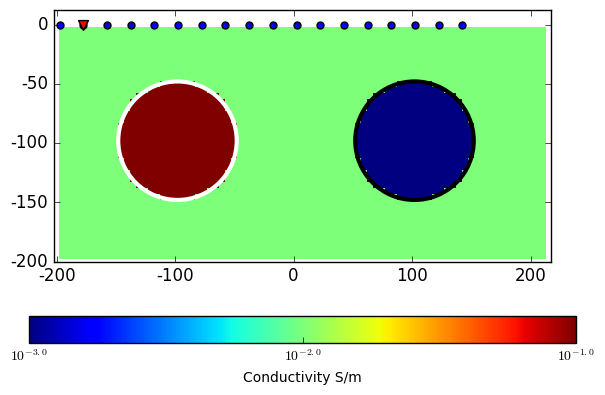

In [111]:
Tx = DCUtils.getSrc_locs(survey2D)
Rx = survey2D.srcList[0].rxList[0].locs

dl_len = np.sqrt( np.sum((endl[0,:] - endl[1,:])**2) )
dl_x = ( Tx[-1][0] - Tx[0][0] ) / dl_len
dl_y = ( Tx[-1][1] - Tx[0][1]  ) / dl_len
azm =  np.arctan(dl_y/dl_x)

#%% Create a 2D mesh along axis of Tx end points and keep z-discretization
dx = np.min( [ np.min(mesh.hx), np.min(mesh.hy), dx_in ])
ncx = np.ceil(dl_len/dx)+3
ncz = np.ceil( depth / dx )

padx = dx*np.power(1.4,range(1,padc))

# Creating padding cells
hx = np.r_[padx[::-1], np.ones(ncx)*dx , padx]
hz = np.r_[padx[::-1], np.ones(ncz)*dx]

# Create 2D mesh
x0 = srvy_end[0][0] - np.sum(padx) * np.cos(azm)
y0 = srvy_end[0][1] - np.sum(padx) * np.sin(azm)
mesh2d = Mesh.TensorMesh([hx, hz], x0=(x0,mesh.vectorNz[-1] - np.sum(hz) ))

#%% Create array of points for interpolating from 3D to 2D mesh
xx = x0 + (np.cumsum(mesh2d.hx) - mesh2d.hx/2) * np.cos(azm)
yy = y0 + (np.cumsum(mesh2d.hx) - mesh2d.hx/2) * np.sin(azm)
zz = mesh2d.vectorCCy

[XX,ZZ] = np.meshgrid(xx,zz)
[YY,ZZ] = np.meshgrid(yy,zz)

xyz2d = np.c_[Utils.mkvc(XX),Utils.mkvc(YY),Utils.mkvc(ZZ)]

F = interpolation.NearestNDInterpolator(mesh.gridCC,model)
m2D = np.reshape(F(xyz2d),[mesh2d.nCx,mesh2d.nCy]).T

#%% Plot a section through the spheres
fig, axs = plt.subplots(1,1, figsize = (6,4))

plt.tight_layout(pad=0.5)

im1 = axs.pcolormesh(mesh2d.vectorCCx,mesh2d.vectorCCy,np.log10(m2D))

# Add colorbar
cbar = fig.colorbar(im1, orientation="horizontal", ticks=np.linspace(vmin,vmax, 3), format="$10^{%.1f}$")
cbar.set_label("Conductivity S/m",size=10)


plt.ylim(zz[0],zz[-1]+3*dx)
plt.xlim(xx[0]-dx,xx[-1]+dx)
plt.gca().set_aspect('equal', adjustable='box')
x = np.linspace(xmin,xmax, 5)
axs.set_xticks(map(int, x))
axs.set_xticklabels(map(str, map(int, x)),size=12)
z = np.linspace(zmin,zmax, 5)
axs.set_yticks(map(int, z))
axs.set_yticklabels(map(str, map(int, z)),size=12)

circle1=plt.Circle((-98,-98),50,color='w',fill=False, lw=3)
circle2=plt.Circle((102,-98),50,color='k',fill=False, lw=3)
axs.add_artist(circle1)
axs.add_artist(circle2)
for ss in range(survey2D.nSrc):
    tx = survey2D.srcList[ss].loc
    axs.scatter(tx[0],tx[2],c='b',s=25)

tx = survey2D.srcList[1].loc
axs.scatter(tx[0],tx[2],c='r',s=50, marker='v')
fig.savefig('TwoSphere_model.png')

In [112]:
#%% Create widget
def removeStream():
    #global im1
    #im1.remove()

    global im2
    im2.remove()
    global im3
    im3.lines.remove()
    axs.patches = []

    global im4
    im4.remove()

    global im5
    im5.remove()

    plt.draw()

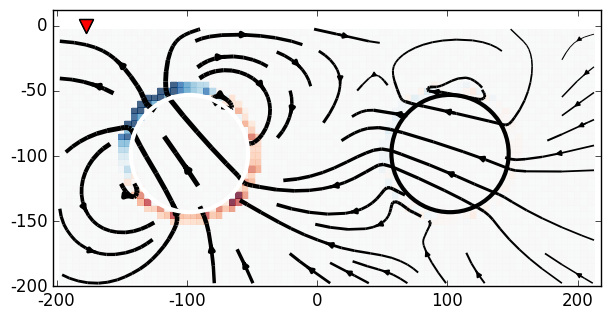

In [117]:

fig, axs = plt.subplots(1,1, figsize = (6,5))
plt.tight_layout(pad=0.5)

im2 = axs.pcolormesh(xx,zz,np.zeros((mesh2d.nCy,mesh2d.nCx)),vmin=-1e-2, vmax=1e-2)

im3 = axs.streamplot(xx, zz, np.zeros((mesh2d.nCy,mesh2d.nCx)), np.zeros((mesh2d.nCy,mesh2d.nCx)),color='k')
im4 = axs.scatter([],[], c='r', s=200)
im5 = axs.scatter([],[], c='r', s=200)

circle1=plt.Circle((-98,-98),45,color='w',fill=False, lw=3)
circle2=plt.Circle((102,-98),45,color='k',fill=False, lw=3)
axs.add_artist(circle1)
axs.add_artist(circle2)

#problem = DC.ProblemDC_CC(mesh)
tinf = np.squeeze(Rx[-1][-1,:3]) + np.array([dl_x,dl_y,0])*10*a
Type = "IP"

def animate(ii):
    
    removeStream()

    if not re.match(stype,'pole-dipole'):

        inds = Utils.closestPoints(mesh, np.asarray(Tx[ii]).T )
        RHS = mesh.getInterpolationMat(np.asarray(Tx[ii]).T, 'CC').T*( [-1,1] / mesh.vol[inds] )

    else:

        # Create an "inifinity" pole
        tx =  np.squeeze(Tx[ii])
        tinf = tx + np.array([dl_x,dl_y,0])*2*dl_len
        inds = Utils.closestPoints(mesh, np.c_[tx,tinf].T)
        RHS = mesh.getInterpolationMat(np.c_[tx,tinf].T, 'CC').T*( [-1,1] / mesh.vol[inds] )

    if Type =="IP":
        phi = Phi0[:,ii] - Phi[:,ii]
        j_CC = JCC0[:,ii] - JCC[:,ii]
        vmin, vmax =-1e-5, 1e-5
    elif Type == "DC":
        phi = Phi[:,ii]
        j_CC = JCC[:,ii]
        vmin, vmax =-1e-4, 1e-4
    # Compute charge density solving div*grad*phi
    Q = -mesh.faceDiv*mesh.cellGrad*phi

    jx_CC = j_CC[0:mesh.nC]
    jy_CC = j_CC[(2*mesh.nC):]

    #%% Grab only the core for presentation
    F = interpolation.NearestNDInterpolator(mesh.gridCC,jx_CC)
    jx_CC_sub =  np.reshape(F(xyz2d),[mesh2d.nCx,mesh2d.nCy]).T

    F = interpolation.NearestNDInterpolator(mesh.gridCC,jy_CC)
    jy_CC_sub =  np.reshape(F(xyz2d),[mesh2d.nCx,mesh2d.nCy]).T

    F = interpolation.NearestNDInterpolator(mesh.gridCC,Q)
    Q_sub = np.reshape(F(xyz2d),[mesh2d.nCx,mesh2d.nCy]).T

    J_rho = np.sqrt(jx_CC_sub**2 + jy_CC_sub**2)
    lw = np.log10(J_rho/J_rho.min())


    global im2
#     if Type=="DC":
        
    im2 = axs.pcolormesh(mesh2d.vectorCCx,mesh2d.vectorCCy,Q_sub, alpha=0.75, clim=[vmin,vmax], vmin=vmin,vmax = vmax, cmap = 'RdBu')

    global im3
    im3 = axs.streamplot(xx, zz, jx_CC_sub/J_rho.max(), jy_CC_sub/J_rho.max(),color='k',density=0.5, linewidth = lw)

    global im4
    im4 = axs.scatter(Tx[ii][0],Tx[ii][2], c='b', s=100, marker='v' )

    global im5
    if stype == "dipole-dipole":
        im5 = axs.scatter(Tx[ii][3],Tx[ii][5], c='r', s=100, marker='v' )
    else:
        im5 = axs.scatter(Tx[ii][0],Tx[ii][2], c='r', s=100, marker='v' )

    plt.ylim(zz[0],zz[-1]+3*dx)
    plt.xlim(xx[0]-dx,xx[-1]+dx)
    axs.set_aspect('equal', adjustable='box')
    x = np.linspace(xmin,xmax, 5)
    axs.set_xticks(map(int, x))
    axs.set_xticklabels(map(str, map(int, x)),size=12)
    z = np.linspace(zmin,zmax, 5)
    axs.set_yticks(map(int, z))
    axs.set_yticklabels(map(str, map(int, z)),size=12)
    
# anim = animation.FuncAnimation(fig, animate,
#                                frames=survey2D.nSrc, interval=500)
#survey2D.nSrc
# anim.save('TwoSphere_IPCurrent_Anim.html', writer=HTMLWriter(embed_frames=True,fps=1))    
animate(1)

In [ ]:
ani